# IMDb with trainer()
2020.09.28

Note: this only use the IMDb data to test the method, haven't apply the model into the 'Anti-Asian' data.

Student: Xuanyu Su                                                                 
Supervisor: Isar Nejadgholi

In [1]:
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
import pandas as pd
train_data = pd.read_csv('Data/Train_comment.csv',sep=',',encoding = "ISO-8859-1")
test_data = pd.read_csv('Data/Test_comment.csv',sep=',',encoding = "ISO-8859-1")
val_data = pd.read_csv('Data/Val_comment.csv',sep=',',encoding = "ISO-8859-1")

In [3]:
def transfer_to_int(temp):
    temp2 = []
    for i in temp:
        if i == 1.0:
            temp2.append(1)
        else:
            temp2.append(0)
    return temp2
        
train_data['attack'] = transfer_to_int(train_data['attack'])
test_data['attack'] = transfer_to_int(test_data['attack'])
val_data['attack'] = transfer_to_int(val_data['attack'])

In [4]:
train_data.head()

,comment,attack
0,newline tokenthis is not creative those are ...,0
1,newline tokennewline token the term standard ...,0
2,newline tokennewline tokentrue or false the si...,0
3,this page will need disambiguation,0
4,newline token newline tokennewline tokenimport...,0


In [5]:
ap=train_data.groupby(by=['attack'])
ap.size()

attack
0    61447
1     8079
dtype: int64

In [6]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [7]:
train_texts = list(train_data['comment'])
test_texts = list(test_data['comment'])
val_texts = list(val_data['comment'])

In [8]:
train_labels = list(train_data['attack'])
test_labels = list(test_data['attack'])
val_labels = list(val_data['attack'])

In [9]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [10]:
import torch

class LoadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = LoadDataset(train_encodings, train_labels)
val_dataset = LoadDataset(val_encodings, val_labels)
test_dataset = LoadDataset(test_encodings, test_labels)

In [11]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [12]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)



trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=val_dataset           
)

trainer.train()

{'loss': 0.6789381027221679, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0011506155793349442, 'step': 10}
{'loss': 0.6679745674133301, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.0023012311586698884, 'step': 20}
{'loss': 0.6377842903137207, 'learning_rate': 3e-06, 'epoch': 0.0034518467380048328, 'step': 30}
{'loss': 0.5821435928344727, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.004602462317339777, 'step': 40}
{'loss': 0.5337764739990234, 'learning_rate': 5e-06, 'epoch': 0.005753077896674721, 'step': 50}
{'loss': 0.47205638885498047, 'learning_rate': 6e-06, 'epoch': 0.0069036934760096655, 'step': 60}
{'loss': 0.4074272155761719, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.00805430905534461, 'step': 70}
{'loss': 0.32754859924316404, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.009204924634679553, 'step': 80}
{'loss': 0.41165885925292967, 'learning_rate': 9e-06, 'epoch': 0.010355540214014497, 'step': 90}
{'loss': 0.3249233245849609, 'learning_rate': 1e

F:\conda\lib\site-packages\torch\optim\lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


{'loss': 0.24466552734375, 'learning_rate': 4.99942136326814e-05, 'epoch': 0.058681394546082156, 'step': 510}
{'loss': 0.2346954345703125, 'learning_rate': 4.998842726536281e-05, 'epoch': 0.0598320101254171, 'step': 520}
{'loss': 0.557586669921875, 'learning_rate': 4.9982640898044206e-05, 'epoch': 0.06098262570475204, 'step': 530}
{'loss': 0.3233734130859375, 'learning_rate': 4.997685453072562e-05, 'epoch': 0.06213324128408699, 'step': 540}
{'loss': 0.15684814453125, 'learning_rate': 4.9971068163407014e-05, 'epoch': 0.06328385686342193, 'step': 550}
{'loss': 0.15361175537109376, 'learning_rate': 4.996528179608842e-05, 'epoch': 0.06443447244275688, 'step': 560}
{'loss': 0.188031005859375, 'learning_rate': 4.995949542876982e-05, 'epoch': 0.06558508802209181, 'step': 570}
{'loss': 0.22762298583984375, 'learning_rate': 4.9953709061451224e-05, 'epoch': 0.06673570360142676, 'step': 580}
{'loss': 0.182525634765625, 'learning_rate': 4.994792269413263e-05, 'epoch': 0.06788631918076171, 'step': 

{'loss': 0.23359375, 'learning_rate': 4.95660224511052e-05, 'epoch': 0.14382694741686802, 'step': 1250}
{'loss': 0.11383056640625, 'learning_rate': 4.95602360837866e-05, 'epoch': 0.14497756299620296, 'step': 1260}
{'loss': 0.275665283203125, 'learning_rate': 4.9554449716468004e-05, 'epoch': 0.14612817857553792, 'step': 1270}
{'loss': 0.3349822998046875, 'learning_rate': 4.954866334914941e-05, 'epoch': 0.14727879415487286, 'step': 1280}
{'loss': 0.3087646484375, 'learning_rate': 4.954287698183081e-05, 'epoch': 0.1484294097342078, 'step': 1290}
{'loss': 0.1477630615234375, 'learning_rate': 4.953709061451221e-05, 'epoch': 0.14958002531354275, 'step': 1300}
{'loss': 0.308270263671875, 'learning_rate': 4.953130424719362e-05, 'epoch': 0.1507306408928777, 'step': 1310}
{'loss': 0.154608154296875, 'learning_rate': 4.9525517879875015e-05, 'epoch': 0.15188125647221262, 'step': 1320}
{'loss': 0.1929901123046875, 'learning_rate': 4.951973151255642e-05, 'epoch': 0.15303187205154758, 'step': 1330}
{

{'loss': 0.3007476806640625, 'learning_rate': 4.914361763684759e-05, 'epoch': 0.22782188470831896, 'step': 1980}
{'loss': 0.241558837890625, 'learning_rate': 4.9137831269528995e-05, 'epoch': 0.2289725002876539, 'step': 1990}
{'loss': 0.0817535400390625, 'learning_rate': 4.913204490221039e-05, 'epoch': 0.23012311586698883, 'step': 2000}
{'loss': 0.1153961181640625, 'learning_rate': 4.9126258534891795e-05, 'epoch': 0.2312737314463238, 'step': 2010}
{'loss': 0.148651123046875, 'learning_rate': 4.91204721675732e-05, 'epoch': 0.23242434702565873, 'step': 2020}
{'loss': 0.1787445068359375, 'learning_rate': 4.91146858002546e-05, 'epoch': 0.23357496260499366, 'step': 2030}
{'loss': 0.1435333251953125, 'learning_rate': 4.9108899432936006e-05, 'epoch': 0.23472557818432863, 'step': 2040}
{'loss': 0.108245849609375, 'learning_rate': 4.910311306561741e-05, 'epoch': 0.23587619376366356, 'step': 2050}
{'loss': 0.202435302734375, 'learning_rate': 4.909732669829881e-05, 'epoch': 0.2370268093429985, 'st

{'loss': 0.088031005859375, 'learning_rate': 4.871542645527138e-05, 'epoch': 0.31296743757910483, 'step': 2720}
{'loss': 0.285882568359375, 'learning_rate': 4.8709640087952786e-05, 'epoch': 0.31411805315843977, 'step': 2730}
{'loss': 0.278369140625, 'learning_rate': 4.870385372063419e-05, 'epoch': 0.3152686687377747, 'step': 2740}
{'loss': 0.189996337890625, 'learning_rate': 4.869806735331559e-05, 'epoch': 0.31641928431710964, 'step': 2750}
{'loss': 0.34010009765625, 'learning_rate': 4.869228098599699e-05, 'epoch': 0.3175698998964446, 'step': 2760}
{'loss': 0.12242431640625, 'learning_rate': 4.86864946186784e-05, 'epoch': 0.31872051547577956, 'step': 2770}
{'loss': 0.096063232421875, 'learning_rate': 4.86807082513598e-05, 'epoch': 0.3198711310551145, 'step': 2780}
{'loss': 0.11544189453125, 'learning_rate': 4.86749218840412e-05, 'epoch': 0.32102174663444943, 'step': 2790}
{'loss': 0.13603515625, 'learning_rate': 4.8669135516722604e-05, 'epoch': 0.32217236221378437, 'step': 2800}
{'loss

{'loss': 0.13021240234375, 'learning_rate': 4.828144890637658e-05, 'epoch': 0.3992636060292256, 'step': 3470}
{'loss': 0.1621337890625, 'learning_rate': 4.827566253905798e-05, 'epoch': 0.4004142216085606, 'step': 3480}
{'loss': 0.229779052734375, 'learning_rate': 4.8269876171739384e-05, 'epoch': 0.40156483718789554, 'step': 3490}
{'loss': 0.2889892578125, 'learning_rate': 4.826408980442079e-05, 'epoch': 0.4027154527672305, 'step': 3500}
{'loss': 0.1158935546875, 'learning_rate': 4.8258303437102184e-05, 'epoch': 0.4038660683465654, 'step': 3510}
{'loss': 0.28541259765625, 'learning_rate': 4.8252517069783594e-05, 'epoch': 0.40501668392590034, 'step': 3520}
{'loss': 0.252130126953125, 'learning_rate': 4.824673070246499e-05, 'epoch': 0.4061672995052353, 'step': 3530}
{'loss': 0.053692626953125, 'learning_rate': 4.82409443351464e-05, 'epoch': 0.40731791508457027, 'step': 3540}
{'loss': 0.10992431640625, 'learning_rate': 4.82351579678278e-05, 'epoch': 0.4084685306639052, 'step': 3550}
{'loss

{'loss': 0.216693115234375, 'learning_rate': 4.784747135748178e-05, 'epoch': 0.48555977447934645, 'step': 4220}
{'loss': 0.094378662109375, 'learning_rate': 4.7841684990163175e-05, 'epoch': 0.4867103900586814, 'step': 4230}
{'loss': 0.1499267578125, 'learning_rate': 4.7835898622844585e-05, 'epoch': 0.4878610056380163, 'step': 4240}
{'loss': 0.148284912109375, 'learning_rate': 4.783011225552598e-05, 'epoch': 0.48901162121735126, 'step': 4250}
{'loss': 0.269140625, 'learning_rate': 4.7824325888207385e-05, 'epoch': 0.49016223679668625, 'step': 4260}
{'loss': 0.067669677734375, 'learning_rate': 4.781853952088879e-05, 'epoch': 0.4913128523760212, 'step': 4270}
{'loss': 0.02489013671875, 'learning_rate': 4.7812753153570186e-05, 'epoch': 0.4924634679553561, 'step': 4280}
{'loss': 0.21763916015625, 'learning_rate': 4.7806966786251596e-05, 'epoch': 0.49361408353469105, 'step': 4290}
{'loss': 0.0723876953125, 'learning_rate': 4.780118041893299e-05, 'epoch': 0.494764699114026, 'step': 4300}
{'los

{'loss': 0.053076171875, 'learning_rate': 4.741349380858697e-05, 'epoch': 0.5718559429294673, 'step': 4970}
{'loss': 0.2024658203125, 'learning_rate': 4.7407707441268376e-05, 'epoch': 0.5730065585088022, 'step': 4980}
{'loss': 0.066998291015625, 'learning_rate': 4.740192107394978e-05, 'epoch': 0.5741571740881372, 'step': 4990}
{'loss': 0.188995361328125, 'learning_rate': 4.7396134706631176e-05, 'epoch': 0.5753077896674721, 'step': 5000}
{'loss': 0.277056884765625, 'learning_rate': 4.739034833931258e-05, 'epoch': 0.576458405246807, 'step': 5010}
{'loss': 0.244970703125, 'learning_rate': 4.7384561971993984e-05, 'epoch': 0.577609020826142, 'step': 5020}
{'loss': 0.136798095703125, 'learning_rate': 4.737877560467539e-05, 'epoch': 0.5787596364054769, 'step': 5030}
{'loss': 0.0359619140625, 'learning_rate': 4.737298923735679e-05, 'epoch': 0.5799102519848118, 'step': 5040}
{'loss': 0.14266357421875, 'learning_rate': 4.7367202870038194e-05, 'epoch': 0.5810608675641468, 'step': 5050}
{'loss': 0

{'loss': 0.389306640625, 'learning_rate': 4.697951625969217e-05, 'epoch': 0.6581521113795881, 'step': 5720}
{'loss': 0.24237060546875, 'learning_rate': 4.697372989237357e-05, 'epoch': 0.659302726958923, 'step': 5730}
{'loss': 0.1494384765625, 'learning_rate': 4.6967943525054974e-05, 'epoch': 0.6604533425382579, 'step': 5740}
{'loss': 0.280859375, 'learning_rate': 4.696215715773638e-05, 'epoch': 0.6616039581175929, 'step': 5750}
{'loss': 0.155517578125, 'learning_rate': 4.6956370790417774e-05, 'epoch': 0.6627545736969278, 'step': 5760}
{'loss': 0.22386474609375, 'learning_rate': 4.695058442309918e-05, 'epoch': 0.6639051892762629, 'step': 5770}
{'loss': 0.1109375, 'learning_rate': 4.694479805578058e-05, 'epoch': 0.6650558048555978, 'step': 5780}
{'loss': 0.079931640625, 'learning_rate': 4.6939011688461985e-05, 'epoch': 0.6662064204349327, 'step': 5790}
{'loss': 0.13184814453125, 'learning_rate': 4.693322532114339e-05, 'epoch': 0.6673570360142677, 'step': 5800}
{'loss': 0.1130126953125, '

{'loss': 0.15633544921875, 'learning_rate': 4.6539752343478765e-05, 'epoch': 0.7455988954090439, 'step': 6480}
{'loss': 0.203662109375, 'learning_rate': 4.653396597616017e-05, 'epoch': 0.7467495109883788, 'step': 6490}
{'loss': 0.17772216796875, 'learning_rate': 4.652817960884157e-05, 'epoch': 0.7479001265677138, 'step': 6500}
{'loss': 0.28519287109375, 'learning_rate': 4.6522393241522976e-05, 'epoch': 0.7490507421470487, 'step': 6510}
{'loss': 0.133642578125, 'learning_rate': 4.651660687420438e-05, 'epoch': 0.7502013577263836, 'step': 6520}
{'loss': 0.1413818359375, 'learning_rate': 4.6510820506885776e-05, 'epoch': 0.7513519733057186, 'step': 6530}
{'loss': 0.2149169921875, 'learning_rate': 4.650503413956718e-05, 'epoch': 0.7525025888850535, 'step': 6540}
{'loss': 0.294384765625, 'learning_rate': 4.649924777224858e-05, 'epoch': 0.7536532044643884, 'step': 6550}
{'loss': 0.3522705078125, 'learning_rate': 4.649346140492999e-05, 'epoch': 0.7548038200437234, 'step': 6560}
{'loss': 0.37050

{'loss': 0.168017578125, 'learning_rate': 4.610577479458396e-05, 'epoch': 0.8318950638591647, 'step': 7230}
{'loss': 0.1497314453125, 'learning_rate': 4.609998842726537e-05, 'epoch': 0.8330456794384996, 'step': 7240}
{'loss': 0.28529052734375, 'learning_rate': 4.609420205994677e-05, 'epoch': 0.8341962950178345, 'step': 7250}
{'loss': 0.37149658203125, 'learning_rate': 4.608841569262817e-05, 'epoch': 0.8353469105971695, 'step': 7260}
{'loss': 0.0809814453125, 'learning_rate': 4.6082629325309574e-05, 'epoch': 0.8364975261765044, 'step': 7270}
{'loss': 0.12889404296875, 'learning_rate': 4.607684295799097e-05, 'epoch': 0.8376481417558393, 'step': 7280}
{'loss': 0.3375732421875, 'learning_rate': 4.607105659067238e-05, 'epoch': 0.8387987573351743, 'step': 7290}
{'loss': 0.18455810546875, 'learning_rate': 4.606527022335378e-05, 'epoch': 0.8399493729145092, 'step': 7300}
{'loss': 0.25927734375, 'learning_rate': 4.605948385603519e-05, 'epoch': 0.8410999884938442, 'step': 7310}
{'loss': 0.124914

{'loss': 0.029541015625, 'learning_rate': 4.5666010878370564e-05, 'epoch': 0.9193418478886204, 'step': 7990}
{'loss': 0.1285888671875, 'learning_rate': 4.566022451105196e-05, 'epoch': 0.9204924634679553, 'step': 8000}
{'loss': 0.21405029296875, 'learning_rate': 4.565443814373337e-05, 'epoch': 0.9216430790472903, 'step': 8010}
{'loss': 0.15606689453125, 'learning_rate': 4.564865177641477e-05, 'epoch': 0.9227936946266252, 'step': 8020}
{'loss': 0.067431640625, 'learning_rate': 4.564286540909617e-05, 'epoch': 0.9239443102059602, 'step': 8030}
{'loss': 0.1140625, 'learning_rate': 4.5637079041777576e-05, 'epoch': 0.9250949257852952, 'step': 8040}
{'loss': 0.2878662109375, 'learning_rate': 4.563129267445897e-05, 'epoch': 0.9262455413646301, 'step': 8050}
{'loss': 0.24425048828125, 'learning_rate': 4.562550630714038e-05, 'epoch': 0.927396156943965, 'step': 8060}
{'loss': 0.34881591796875, 'learning_rate': 4.561971993982178e-05, 'epoch': 0.9285467725233, 'step': 8070}
{'loss': 0.24368896484375

{'loss': 0.1271240234375, 'learning_rate': 4.5255178798750145e-05, 'epoch': 1.0010355540214015, 'step': 8700}
{'loss': 0.1448486328125, 'learning_rate': 4.524939243143155e-05, 'epoch': 1.0021861696007364, 'step': 8710}
{'loss': 0.2266845703125, 'learning_rate': 4.524360606411295e-05, 'epoch': 1.0033367851800714, 'step': 8720}
{'loss': 0.15980224609375, 'learning_rate': 4.5237819696794355e-05, 'epoch': 1.0044874007594062, 'step': 8730}
{'loss': 0.12781982421875, 'learning_rate': 4.523203332947576e-05, 'epoch': 1.0056380163387413, 'step': 8740}
{'loss': 0.3936767578125, 'learning_rate': 4.522624696215716e-05, 'epoch': 1.006788631918076, 'step': 8750}
{'loss': 0.1609375, 'learning_rate': 4.5220460594838566e-05, 'epoch': 1.0079392474974112, 'step': 8760}
{'loss': 0.21375732421875, 'learning_rate': 4.521467422751996e-05, 'epoch': 1.009089863076746, 'step': 8770}
{'loss': 0.10887451171875, 'learning_rate': 4.5208887860201367e-05, 'epoch': 1.010240478656081, 'step': 8780}
{'loss': 0.302722167

{'loss': 0.006689453125, 'learning_rate': 4.481541488253674e-05, 'epoch': 1.0884823380508573, 'step': 9460}
{'loss': 0.23802490234375, 'learning_rate': 4.4809628515218146e-05, 'epoch': 1.089632953630192, 'step': 9470}
{'loss': 0.15347900390625, 'learning_rate': 4.480384214789955e-05, 'epoch': 1.0907835692095271, 'step': 9480}
{'loss': 0.16856689453125, 'learning_rate': 4.4798055780580953e-05, 'epoch': 1.091934184788862, 'step': 9490}
{'loss': 0.22080078125, 'learning_rate': 4.479226941326236e-05, 'epoch': 1.093084800368197, 'step': 9500}
{'loss': 0.11279296875, 'learning_rate': 4.478648304594376e-05, 'epoch': 1.0942354159475318, 'step': 9510}
{'loss': 0.10782470703125, 'learning_rate': 4.4780696678625164e-05, 'epoch': 1.0953860315268669, 'step': 9520}
{'loss': 0.26951904296875, 'learning_rate': 4.477491031130656e-05, 'epoch': 1.096536647106202, 'step': 9530}
{'loss': 0.09449462890625, 'learning_rate': 4.4769123943987965e-05, 'epoch': 1.0976872626855367, 'step': 9540}
{'loss': 0.1794067

{'loss': 0.1804931640625, 'learning_rate': 4.438143733364194e-05, 'epoch': 1.174778506500978, 'step': 10210}
{'loss': 0.28697509765625, 'learning_rate': 4.437565096632335e-05, 'epoch': 1.175929122080313, 'step': 10220}
{'loss': 0.22027587890625, 'learning_rate': 4.4369864599004744e-05, 'epoch': 1.177079737659648, 'step': 10230}
{'loss': 0.077001953125, 'learning_rate': 4.4364078231686155e-05, 'epoch': 1.1782303532389828, 'step': 10240}
{'loss': 0.112060546875, 'learning_rate': 4.435829186436755e-05, 'epoch': 1.1793809688183179, 'step': 10250}
{'loss': 0.2203369140625, 'learning_rate': 4.4352505497048955e-05, 'epoch': 1.1805315843976527, 'step': 10260}
{'loss': 0.12027587890625, 'learning_rate': 4.434671912973036e-05, 'epoch': 1.1816821999769878, 'step': 10270}
{'loss': 0.119775390625, 'learning_rate': 4.4340932762411756e-05, 'epoch': 1.1828328155563226, 'step': 10280}
{'loss': 0.11070556640625, 'learning_rate': 4.4335146395093166e-05, 'epoch': 1.1839834311356576, 'step': 10290}
{'loss'

{'loss': 0.13250732421875, 'learning_rate': 4.394745978474714e-05, 'epoch': 1.2610746749510988, 'step': 10960}
{'loss': 0.2387451171875, 'learning_rate': 4.394167341742854e-05, 'epoch': 1.2622252905304339, 'step': 10970}
{'loss': 0.105712890625, 'learning_rate': 4.393588705010994e-05, 'epoch': 1.2633759061097687, 'step': 10980}
{'loss': 0.04486083984375, 'learning_rate': 4.393010068279135e-05, 'epoch': 1.2645265216891037, 'step': 10990}
{'loss': 0.1542236328125, 'learning_rate': 4.3924314315472746e-05, 'epoch': 1.2656771372684386, 'step': 11000}
{'loss': 0.2324951171875, 'learning_rate': 4.3918527948154156e-05, 'epoch': 1.2668277528477736, 'step': 11010}
{'loss': 0.13916015625, 'learning_rate': 4.391274158083555e-05, 'epoch': 1.2679783684271084, 'step': 11020}
{'loss': 0.1700439453125, 'learning_rate': 4.390695521351696e-05, 'epoch': 1.2691289840064435, 'step': 11030}
{'loss': 0.177099609375, 'learning_rate': 4.390116884619836e-05, 'epoch': 1.2702795995857783, 'step': 11040}
{'loss': 0

{'loss': 0.181201171875, 'learning_rate': 4.351348223585233e-05, 'epoch': 1.3473708434012197, 'step': 11710}
{'loss': 0.1755615234375, 'learning_rate': 4.350769586853374e-05, 'epoch': 1.3485214589805545, 'step': 11720}
{'loss': 0.1558349609375, 'learning_rate': 4.350190950121514e-05, 'epoch': 1.3496720745598896, 'step': 11730}
{'loss': 0.190771484375, 'learning_rate': 4.3496123133896544e-05, 'epoch': 1.3508226901392244, 'step': 11740}
{'loss': 0.190771484375, 'learning_rate': 4.349033676657794e-05, 'epoch': 1.3519733057185594, 'step': 11750}
{'loss': 0.1235107421875, 'learning_rate': 4.348455039925935e-05, 'epoch': 1.3531239212978945, 'step': 11760}
{'loss': 0.215380859375, 'learning_rate': 4.347876403194075e-05, 'epoch': 1.3542745368772293, 'step': 11770}
{'loss': 0.2252685546875, 'learning_rate': 4.347297766462215e-05, 'epoch': 1.3554251524565641, 'step': 11780}
{'loss': 0.2124267578125, 'learning_rate': 4.3467191297303555e-05, 'epoch': 1.3565757680358992, 'step': 11790}
{'loss': 0.1

{'loss': 0.2619873046875, 'learning_rate': 4.307950468695753e-05, 'epoch': 1.4336670118513406, 'step': 12460}
{'loss': 0.1444091796875, 'learning_rate': 4.307371831963893e-05, 'epoch': 1.4348176274306754, 'step': 12470}
{'loss': 0.0803955078125, 'learning_rate': 4.3067931952320335e-05, 'epoch': 1.4359682430100102, 'step': 12480}
{'loss': 0.030078125, 'learning_rate': 4.306214558500174e-05, 'epoch': 1.4371188585893453, 'step': 12490}
{'loss': 0.21767578125, 'learning_rate': 4.305635921768314e-05, 'epoch': 1.4382694741686803, 'step': 12500}
{'loss': 0.0590087890625, 'learning_rate': 4.3050572850364546e-05, 'epoch': 1.4394200897480152, 'step': 12510}
{'loss': 0.331494140625, 'learning_rate': 4.304478648304594e-05, 'epoch': 1.4405707053273502, 'step': 12520}
{'loss': 0.142333984375, 'learning_rate': 4.3039000115727346e-05, 'epoch': 1.441721320906685, 'step': 12530}
{'loss': 0.09091796875, 'learning_rate': 4.303321374840875e-05, 'epoch': 1.44287193648602, 'step': 12540}
{'loss': 0.143823242

{'loss': 0.03046875, 'learning_rate': 4.264552713806272e-05, 'epoch': 1.5199631803014613, 'step': 13210}
{'loss': 0.06923828125, 'learning_rate': 4.263974077074413e-05, 'epoch': 1.521113795880796, 'step': 13220}
{'loss': 0.248291015625, 'learning_rate': 4.263395440342553e-05, 'epoch': 1.5222644114601311, 'step': 13230}
{'loss': 0.031494140625, 'learning_rate': 4.262816803610693e-05, 'epoch': 1.5234150270394662, 'step': 13240}
{'loss': 0.192333984375, 'learning_rate': 4.2622381668788336e-05, 'epoch': 1.524565642618801, 'step': 13250}
{'loss': 0.1218505859375, 'learning_rate': 4.261659530146974e-05, 'epoch': 1.525716258198136, 'step': 13260}
{'loss': 0.1989013671875, 'learning_rate': 4.2610808934151144e-05, 'epoch': 1.5268668737774709, 'step': 13270}
{'loss': 0.1174560546875, 'learning_rate': 4.260502256683254e-05, 'epoch': 1.528017489356806, 'step': 13280}
{'loss': 0.066845703125, 'learning_rate': 4.259923619951395e-05, 'epoch': 1.529168104936141, 'step': 13290}
{'loss': 0.0384521484375

{'loss': 0.20380859375, 'learning_rate': 4.220576322184933e-05, 'epoch': 1.607409964330917, 'step': 13970}
{'loss': 0.1750244140625, 'learning_rate': 4.2199976854530724e-05, 'epoch': 1.608560579910252, 'step': 13980}
{'loss': 0.155712890625, 'learning_rate': 4.2194190487212134e-05, 'epoch': 1.609711195489587, 'step': 13990}
{'loss': 0.1539306640625, 'learning_rate': 4.218840411989353e-05, 'epoch': 1.610861811068922, 'step': 14000}
{'loss': 0.2267333984375, 'learning_rate': 4.2182617752574935e-05, 'epoch': 1.6120124266482567, 'step': 14010}
{'loss': 0.1596435546875, 'learning_rate': 4.217683138525634e-05, 'epoch': 1.6131630422275918, 'step': 14020}
{'loss': 0.0480712890625, 'learning_rate': 4.2171045017937735e-05, 'epoch': 1.6143136578069268, 'step': 14030}
{'loss': 0.043798828125, 'learning_rate': 4.2165258650619145e-05, 'epoch': 1.6154642733862616, 'step': 14040}
{'loss': 0.2280029296875, 'learning_rate': 4.215947228330054e-05, 'epoch': 1.6166148889655965, 'step': 14050}
{'loss': 0.34

{'loss': 0.193603515625, 'learning_rate': 4.1765999305635925e-05, 'epoch': 1.694856748360373, 'step': 14730}
{'loss': 0.191455078125, 'learning_rate': 4.176021293831733e-05, 'epoch': 1.6960073639397077, 'step': 14740}
{'loss': 0.111767578125, 'learning_rate': 4.1754426570998726e-05, 'epoch': 1.6971579795190426, 'step': 14750}
{'loss': 0.2630615234375, 'learning_rate': 4.1748640203680136e-05, 'epoch': 1.6983085950983776, 'step': 14760}
{'loss': 0.021044921875, 'learning_rate': 4.174285383636153e-05, 'epoch': 1.6994592106777127, 'step': 14770}
{'loss': 0.2309814453125, 'learning_rate': 4.1737067469042936e-05, 'epoch': 1.7006098262570475, 'step': 14780}
{'loss': 0.0463623046875, 'learning_rate': 4.173128110172434e-05, 'epoch': 1.7017604418363823, 'step': 14790}
{'loss': 0.1091796875, 'learning_rate': 4.172549473440574e-05, 'epoch': 1.7029110574157174, 'step': 14800}
{'loss': 0.279052734375, 'learning_rate': 4.171970836708715e-05, 'epoch': 1.7040616729950524, 'step': 14810}
{'loss': 0.0519

{'loss': 0.1295654296875, 'learning_rate': 4.132623538942252e-05, 'epoch': 1.7823035323898284, 'step': 15490}
{'loss': 0.11552734375, 'learning_rate': 4.132044902210393e-05, 'epoch': 1.7834541479691635, 'step': 15500}
{'loss': 0.092138671875, 'learning_rate': 4.131466265478533e-05, 'epoch': 1.7846047635484985, 'step': 15510}
{'loss': 0.16962890625, 'learning_rate': 4.130887628746673e-05, 'epoch': 1.7857553791278336, 'step': 15520}
{'loss': 0.084228515625, 'learning_rate': 4.130308992014813e-05, 'epoch': 1.7869059947071684, 'step': 15530}
{'loss': 0.21953125, 'learning_rate': 4.1297303552829534e-05, 'epoch': 1.7880566102865032, 'step': 15540}
{'loss': 0.2576171875, 'learning_rate': 4.129151718551094e-05, 'epoch': 1.7892072258658382, 'step': 15550}
{'loss': 0.19130859375, 'learning_rate': 4.128573081819234e-05, 'epoch': 1.7903578414451733, 'step': 15560}
{'loss': 0.1903564453125, 'learning_rate': 4.1279944450873745e-05, 'epoch': 1.7915084570245081, 'step': 15570}
{'loss': 0.0791748046875

{'loss': 0.1699462890625, 'learning_rate': 4.088647147320912e-05, 'epoch': 1.8697503164192844, 'step': 16250}
{'loss': 0.186669921875, 'learning_rate': 4.0880685105890525e-05, 'epoch': 1.8709009319986194, 'step': 16260}
{'loss': 0.183740234375, 'learning_rate': 4.087489873857193e-05, 'epoch': 1.8720515475779542, 'step': 16270}
{'loss': 0.1127197265625, 'learning_rate': 4.0869112371253325e-05, 'epoch': 1.873202163157289, 'step': 16280}
{'loss': 0.081689453125, 'learning_rate': 4.086332600393473e-05, 'epoch': 1.874352778736624, 'step': 16290}
{'loss': 0.2030029296875, 'learning_rate': 4.085753963661613e-05, 'epoch': 1.8755033943159591, 'step': 16300}
{'loss': 0.072509765625, 'learning_rate': 4.0851753269297536e-05, 'epoch': 1.876654009895294, 'step': 16310}
{'loss': 0.27158203125, 'learning_rate': 4.084596690197894e-05, 'epoch': 1.8778046254746288, 'step': 16320}
{'loss': 0.0894287109375, 'learning_rate': 4.084018053466034e-05, 'epoch': 1.8789552410539638, 'step': 16330}
{'loss': 0.04865

{'loss': 0.106689453125, 'learning_rate': 4.044670755699572e-05, 'epoch': 1.95719710044874, 'step': 17010}
{'loss': 0.32529296875, 'learning_rate': 4.044092118967712e-05, 'epoch': 1.958347716028075, 'step': 17020}
{'loss': 0.3010986328125, 'learning_rate': 4.043513482235853e-05, 'epoch': 1.95949833160741, 'step': 17030}
{'loss': 0.0433349609375, 'learning_rate': 4.042934845503993e-05, 'epoch': 1.960648947186745, 'step': 17040}
{'loss': 0.051953125, 'learning_rate': 4.042356208772133e-05, 'epoch': 1.9617995627660798, 'step': 17050}
{'loss': 0.1137451171875, 'learning_rate': 4.041777572040274e-05, 'epoch': 1.9629501783454146, 'step': 17060}
{'loss': 0.1223876953125, 'learning_rate': 4.0411989353084134e-05, 'epoch': 1.9641007939247497, 'step': 17070}
{'loss': 0.1230224609375, 'learning_rate': 4.040620298576554e-05, 'epoch': 1.9652514095040847, 'step': 17080}
{'loss': 0.0194580078125, 'learning_rate': 4.040041661844694e-05, 'epoch': 1.9664020250834198, 'step': 17090}
{'loss': 0.107421875, 

{'loss': 0.0394775390625, 'learning_rate': 4.0226825598889015e-05, 'epoch': 2.000920492463468, 'step': 17390}
{'loss': 0.0987548828125, 'learning_rate': 4.0221039231570426e-05, 'epoch': 2.002071108042803, 'step': 17400}
{'loss': 0.17646484375, 'learning_rate': 4.021525286425182e-05, 'epoch': 2.0032217236221377, 'step': 17410}
{'loss': 0.1853759765625, 'learning_rate': 4.0209466496933226e-05, 'epoch': 2.0043723392014727, 'step': 17420}
{'loss': 0.06943359375, 'learning_rate': 4.020368012961463e-05, 'epoch': 2.0055229547808078, 'step': 17430}
{'loss': 0.0691650390625, 'learning_rate': 4.019789376229603e-05, 'epoch': 2.006673570360143, 'step': 17440}
{'loss': 0.237353515625, 'learning_rate': 4.019210739497744e-05, 'epoch': 2.0078241859394774, 'step': 17450}
{'loss': 0.206201171875, 'learning_rate': 4.0186321027658834e-05, 'epoch': 2.0089748015188125, 'step': 17460}
{'loss': 0.2096923828125, 'learning_rate': 4.0180534660340244e-05, 'epoch': 2.0101254170981475, 'step': 17470}
{'loss': 0.059

{'loss': 0.1879638671875, 'learning_rate': 3.978706168267562e-05, 'epoch': 2.0883672764929235, 'step': 18150}
{'loss': 0.191455078125, 'learning_rate': 3.978127531535702e-05, 'epoch': 2.0895178920722586, 'step': 18160}
{'loss': 0.249951171875, 'learning_rate': 3.977548894803843e-05, 'epoch': 2.0906685076515936, 'step': 18170}
{'loss': 0.1010498046875, 'learning_rate': 3.9769702580719824e-05, 'epoch': 2.0918191232309287, 'step': 18180}
{'loss': 0.06064453125, 'learning_rate': 3.9763916213401234e-05, 'epoch': 2.0929697388102637, 'step': 18190}
{'loss': 0.12998046875, 'learning_rate': 3.975812984608263e-05, 'epoch': 2.0941203543895983, 'step': 18200}
{'loss': 0.0767333984375, 'learning_rate': 3.9752343478764035e-05, 'epoch': 2.0952709699689334, 'step': 18210}
{'loss': 0.0985107421875, 'learning_rate': 3.974655711144544e-05, 'epoch': 2.0964215855482684, 'step': 18220}
{'loss': 0.0599853515625, 'learning_rate': 3.9740770744126835e-05, 'epoch': 2.0975722011276035, 'step': 18230}
{'loss': 0.1

{'loss': 0.1326904296875, 'learning_rate': 3.934729776646222e-05, 'epoch': 2.1758140605223795, 'step': 18910}
{'loss': 0.11484375, 'learning_rate': 3.934151139914362e-05, 'epoch': 2.1769646761017145, 'step': 18920}
{'loss': 0.23994140625, 'learning_rate': 3.933572503182502e-05, 'epoch': 2.1781152916810496, 'step': 18930}
{'loss': 0.1341796875, 'learning_rate': 3.932993866450643e-05, 'epoch': 2.179265907260384, 'step': 18940}
{'loss': 0.042626953125, 'learning_rate': 3.9324152297187826e-05, 'epoch': 2.180416522839719, 'step': 18950}
{'loss': 0.016748046875, 'learning_rate': 3.931836592986923e-05, 'epoch': 2.1815671384190543, 'step': 18960}
{'loss': 0.043212890625, 'learning_rate': 3.931257956255063e-05, 'epoch': 2.1827177539983893, 'step': 18970}
{'loss': 0.2281982421875, 'learning_rate': 3.9306793195232037e-05, 'epoch': 2.183868369577724, 'step': 18980}
{'loss': 0.0259033203125, 'learning_rate': 3.930100682791344e-05, 'epoch': 2.185018985157059, 'step': 18990}
{'loss': 0.105224609375, 

{'loss': 0.19150390625, 'learning_rate': 3.8907533850248816e-05, 'epoch': 2.2632608445518354, 'step': 19670}
{'loss': 0.3200927734375, 'learning_rate': 3.890174748293022e-05, 'epoch': 2.26441146013117, 'step': 19680}
{'loss': 0.1224365234375, 'learning_rate': 3.8895961115611623e-05, 'epoch': 2.265562075710505, 'step': 19690}
{'loss': 0.0929443359375, 'learning_rate': 3.889017474829302e-05, 'epoch': 2.26671269128984, 'step': 19700}
{'loss': 0.1027587890625, 'learning_rate': 3.8884388380974424e-05, 'epoch': 2.267863306869175, 'step': 19710}
{'loss': 0.04931640625, 'learning_rate': 3.887860201365583e-05, 'epoch': 2.2690139224485097, 'step': 19720}
{'loss': 0.01796875, 'learning_rate': 3.887281564633723e-05, 'epoch': 2.270164538027845, 'step': 19730}
{'loss': 0.170654296875, 'learning_rate': 3.8867029279018635e-05, 'epoch': 2.27131515360718, 'step': 19740}
{'loss': 0.211474609375, 'learning_rate': 3.886124291170004e-05, 'epoch': 2.272465769186515, 'step': 19750}
{'loss': 0.0098876953125, '

{'loss': 0.1557861328125, 'learning_rate': 3.8467769934035414e-05, 'epoch': 2.350707628581291, 'step': 20430}
{'loss': 0.1353271484375, 'learning_rate': 3.846198356671682e-05, 'epoch': 2.351858244160626, 'step': 20440}
{'loss': 0.1774169921875, 'learning_rate': 3.845619719939822e-05, 'epoch': 2.353008859739961, 'step': 20450}
{'loss': 0.0792236328125, 'learning_rate': 3.845041083207962e-05, 'epoch': 2.354159475319296, 'step': 20460}
{'loss': 0.094921875, 'learning_rate': 3.844462446476103e-05, 'epoch': 2.3553100908986306, 'step': 20470}
{'loss': 0.19365234375, 'learning_rate': 3.8438838097442426e-05, 'epoch': 2.3564607064779657, 'step': 20480}
{'loss': 0.0816162109375, 'learning_rate': 3.843305173012383e-05, 'epoch': 2.3576113220573007, 'step': 20490}
{'loss': 0.0818603515625, 'learning_rate': 3.842726536280523e-05, 'epoch': 2.3587619376366358, 'step': 20500}
{'loss': 0.13779296875, 'learning_rate': 3.8421478995486636e-05, 'epoch': 2.3599125532159704, 'step': 20510}
{'loss': 0.07233886

{'loss': 0.0501708984375, 'learning_rate': 3.802800601782201e-05, 'epoch': 2.438154412610747, 'step': 21190}
{'loss': 0.1606201171875, 'learning_rate': 3.8022219650503416e-05, 'epoch': 2.439305028190082, 'step': 21200}
{'loss': 0.0990478515625, 'learning_rate': 3.801643328318481e-05, 'epoch': 2.4404556437694165, 'step': 21210}
{'loss': 0.1480712890625, 'learning_rate': 3.801064691586622e-05, 'epoch': 2.4416062593487515, 'step': 21220}
{'loss': 0.176708984375, 'learning_rate': 3.800486054854762e-05, 'epoch': 2.4427568749280866, 'step': 21230}
{'loss': 0.1047607421875, 'learning_rate': 3.799907418122903e-05, 'epoch': 2.4439074905074216, 'step': 21240}
{'loss': 0.162890625, 'learning_rate': 3.799328781391043e-05, 'epoch': 2.4450581060867562, 'step': 21250}
{'loss': 0.1950439453125, 'learning_rate': 3.798750144659183e-05, 'epoch': 2.4462087216660913, 'step': 21260}
{'loss': 0.17529296875, 'learning_rate': 3.7981715079273234e-05, 'epoch': 2.4473593372454263, 'step': 21270}
{'loss': 0.180444

{'loss': 0.26513671875, 'learning_rate': 3.758824210160861e-05, 'epoch': 2.5256011966402028, 'step': 21950}
{'loss': 0.0824462890625, 'learning_rate': 3.7582455734290014e-05, 'epoch': 2.5267518122195374, 'step': 21960}
{'loss': 0.060107421875, 'learning_rate': 3.757666936697142e-05, 'epoch': 2.5279024277988724, 'step': 21970}
{'loss': 0.2893798828125, 'learning_rate': 3.7570882999652815e-05, 'epoch': 2.5290530433782075, 'step': 21980}
{'loss': 0.054443359375, 'learning_rate': 3.7565096632334225e-05, 'epoch': 2.530203658957542, 'step': 21990}
{'loss': 0.268310546875, 'learning_rate': 3.755931026501562e-05, 'epoch': 2.531354274536877, 'step': 22000}
{'loss': 0.0969482421875, 'learning_rate': 3.755352389769703e-05, 'epoch': 2.532504890116212, 'step': 22010}
{'loss': 0.21435546875, 'learning_rate': 3.754773753037843e-05, 'epoch': 2.533655505695547, 'step': 22020}
{'loss': 0.085009765625, 'learning_rate': 3.754195116305983e-05, 'epoch': 2.5348061212748823, 'step': 22030}
{'loss': 0.25883789

{'loss': 0.056201171875, 'learning_rate': 3.714847818539521e-05, 'epoch': 2.6130479806696583, 'step': 22710}
{'loss': 0.033740234375, 'learning_rate': 3.714269181807661e-05, 'epoch': 2.6141985962489933, 'step': 22720}
{'loss': 0.170654296875, 'learning_rate': 3.7136905450758016e-05, 'epoch': 2.6153492118283284, 'step': 22730}
{'loss': 0.1029296875, 'learning_rate': 3.713111908343942e-05, 'epoch': 2.616499827407663, 'step': 22740}
{'loss': 0.1009033203125, 'learning_rate': 3.712533271612082e-05, 'epoch': 2.617650442986998, 'step': 22750}
{'loss': 0.1425537109375, 'learning_rate': 3.711954634880223e-05, 'epoch': 2.618801058566333, 'step': 22760}
{'loss': 0.09453125, 'learning_rate': 3.7113759981483624e-05, 'epoch': 2.619951674145668, 'step': 22770}
{'loss': 0.22431640625, 'learning_rate': 3.7107973614165034e-05, 'epoch': 2.6211022897250027, 'step': 22780}
{'loss': 0.1086669921875, 'learning_rate': 3.710218724684643e-05, 'epoch': 2.6222529053043377, 'step': 22790}
{'loss': 0.0162841796875

{'loss': 0.2955322265625, 'learning_rate': 3.670871426918181e-05, 'epoch': 2.7004947646991138, 'step': 23470}
{'loss': 0.163037109375, 'learning_rate': 3.670292790186321e-05, 'epoch': 2.701645380278449, 'step': 23480}
{'loss': 0.1311279296875, 'learning_rate': 3.6697141534544614e-05, 'epoch': 2.702795995857784, 'step': 23490}
{'loss': 0.08447265625, 'learning_rate': 3.669135516722602e-05, 'epoch': 2.703946611437119, 'step': 23500}
{'loss': 0.043798828125, 'learning_rate': 3.668556879990742e-05, 'epoch': 2.705097227016454, 'step': 23510}
{'loss': 0.101611328125, 'learning_rate': 3.6679782432588825e-05, 'epoch': 2.706247842595789, 'step': 23520}
{'loss': 0.1262939453125, 'learning_rate': 3.667399606527023e-05, 'epoch': 2.7073984581751236, 'step': 23530}
{'loss': 0.3130859375, 'learning_rate': 3.6668209697951625e-05, 'epoch': 2.7085490737544586, 'step': 23540}
{'loss': 0.0942138671875, 'learning_rate': 3.666242333063303e-05, 'epoch': 2.7096996893337937, 'step': 23550}
{'loss': 0.127465820

{'loss': 0.18359375, 'learning_rate': 3.6268950352968405e-05, 'epoch': 2.7879415487285697, 'step': 24230}
{'loss': 0.0213134765625, 'learning_rate': 3.626316398564981e-05, 'epoch': 2.7890921643079047, 'step': 24240}
{'loss': 0.185400390625, 'learning_rate': 3.625737761833121e-05, 'epoch': 2.79024277988724, 'step': 24250}
{'loss': 0.033056640625, 'learning_rate': 3.6251591251012616e-05, 'epoch': 2.7913933954665744, 'step': 24260}
{'loss': 0.1199951171875, 'learning_rate': 3.624580488369402e-05, 'epoch': 2.7925440110459094, 'step': 24270}
{'loss': 0.0361328125, 'learning_rate': 3.624001851637542e-05, 'epoch': 2.7936946266252445, 'step': 24280}
{'loss': 0.036669921875, 'learning_rate': 3.6234232149056827e-05, 'epoch': 2.7948452422045795, 'step': 24290}
{'loss': 0.1125732421875, 'learning_rate': 3.622844578173822e-05, 'epoch': 2.7959958577839146, 'step': 24300}
{'loss': 0.2782470703125, 'learning_rate': 3.622265941441963e-05, 'epoch': 2.797146473363249, 'step': 24310}
{'loss': 0.1491210937

{'loss': 0.0667236328125, 'learning_rate': 3.582918643675501e-05, 'epoch': 2.8753883327580256, 'step': 24990}
{'loss': 0.0908203125, 'learning_rate': 3.582340006943641e-05, 'epoch': 2.8765389483373607, 'step': 25000}
{'loss': 0.137451171875, 'learning_rate': 3.581761370211782e-05, 'epoch': 2.8776895639166953, 'step': 25010}
{'loss': 0.1492919921875, 'learning_rate': 3.5811827334799214e-05, 'epoch': 2.8788401794960303, 'step': 25020}
{'loss': 0.01181640625, 'learning_rate': 3.580604096748062e-05, 'epoch': 2.8799907950753654, 'step': 25030}
{'loss': 0.0651123046875, 'learning_rate': 3.580025460016202e-05, 'epoch': 2.8811414106547004, 'step': 25040}
{'loss': 0.00595703125, 'learning_rate': 3.579446823284342e-05, 'epoch': 2.882292026234035, 'step': 25050}
{'loss': 0.140966796875, 'learning_rate': 3.578868186552483e-05, 'epoch': 2.88344264181337, 'step': 25060}
{'loss': 0.018310546875, 'learning_rate': 3.5782895498206225e-05, 'epoch': 2.884593257392705, 'step': 25070}
{'loss': 0.262109375, 

{'loss': 0.1767578125, 'learning_rate': 3.53894225205416e-05, 'epoch': 2.962835116787481, 'step': 25750}
{'loss': 0.1521484375, 'learning_rate': 3.538363615322301e-05, 'epoch': 2.963985732366816, 'step': 25760}
{'loss': 0.178662109375, 'learning_rate': 3.537784978590441e-05, 'epoch': 2.965136347946151, 'step': 25770}
{'loss': 0.095947265625, 'learning_rate': 3.537206341858582e-05, 'epoch': 2.9662869635254863, 'step': 25780}
{'loss': 0.23056640625, 'learning_rate': 3.5366277051267216e-05, 'epoch': 2.9674375791048213, 'step': 25790}
{'loss': 0.122119140625, 'learning_rate': 3.536049068394862e-05, 'epoch': 2.968588194684156, 'step': 25800}
{'loss': 0.1650390625, 'learning_rate': 3.535470431663002e-05, 'epoch': 2.969738810263491, 'step': 25810}
{'loss': 0.077587890625, 'learning_rate': 3.534891794931142e-05, 'epoch': 2.970889425842826, 'step': 25820}
{'loss': 0.04716796875, 'learning_rate': 3.534313158199283e-05, 'epoch': 2.9720400414221606, 'step': 25830}
{'loss': 0.091552734375, 'learnin

{'loss': 0.0076171875, 'learning_rate': 3.519847239902789e-05, 'epoch': 3.0008054309055345, 'step': 26080}
{'loss': 0.0845703125, 'learning_rate': 3.5192686031709296e-05, 'epoch': 3.0019560464848696, 'step': 26090}
{'loss': 0.19765625, 'learning_rate': 3.51868996643907e-05, 'epoch': 3.003106662064204, 'step': 26100}
{'loss': 0.0826171875, 'learning_rate': 3.5181113297072096e-05, 'epoch': 3.0042572776435392, 'step': 26110}
{'loss': 0.052880859375, 'learning_rate': 3.517532692975351e-05, 'epoch': 3.0054078932228743, 'step': 26120}
{'loss': 0.08955078125, 'learning_rate': 3.5169540562434904e-05, 'epoch': 3.0065585088022093, 'step': 26130}
{'loss': 0.02451171875, 'learning_rate': 3.516375419511631e-05, 'epoch': 3.007709124381544, 'step': 26140}
{'loss': 0.110107421875, 'learning_rate': 3.515796782779771e-05, 'epoch': 3.008859739960879, 'step': 26150}
{'loss': 0.218212890625, 'learning_rate': 3.5152181460479114e-05, 'epoch': 3.010010355540214, 'step': 26160}
{'loss': 0.084423828125, 'learni

{'loss': 0.2046875, 'learning_rate': 3.4752922115495894e-05, 'epoch': 3.089402830514325, 'step': 26850}
{'loss': 0.0126953125, 'learning_rate': 3.47471357481773e-05, 'epoch': 3.09055344609366, 'step': 26860}
{'loss': 0.195703125, 'learning_rate': 3.47413493808587e-05, 'epoch': 3.091704061672995, 'step': 26870}
{'loss': 0.13515625, 'learning_rate': 3.47355630135401e-05, 'epoch': 3.09285467725233, 'step': 26880}
{'loss': 0.16728515625, 'learning_rate': 3.47297766462215e-05, 'epoch': 3.094005292831665, 'step': 26890}
{'loss': 0.155029296875, 'learning_rate': 3.4723990278902905e-05, 'epoch': 3.095155908411, 'step': 26900}
{'loss': 0.1712890625, 'learning_rate': 3.471820391158431e-05, 'epoch': 3.096306523990335, 'step': 26910}
{'loss': 0.0779296875, 'learning_rate': 3.471241754426571e-05, 'epoch': 3.09745713956967, 'step': 26920}
{'loss': 0.05107421875, 'learning_rate': 3.4706631176947116e-05, 'epoch': 3.0986077551490046, 'step': 26930}
{'loss': 0.132470703125, 'learning_rate': 3.4700844809

KeyboardInterrupt: 

In [1]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 8381), started 2 days, 22:33:43 ago. (Use '!kill 8381' to kill it.)

In [24]:
prediction = trainer.predict(test_dataset)

In [46]:
y_true = test_labels
y_prob = list(prediction.predictions)

In [50]:
prediction.predictions

array([[ 4.528773 , -4.747718 ],
       [ 4.0888805, -4.235291 ],
       [ 4.621149 , -4.8668046],
       ...,
       [ 4.401537 , -4.5886173],
       [ 3.90787  , -4.0405345],
       [ 4.5277004, -4.746372 ]], dtype=float32)

In [61]:
len(y_true)

23178

In [58]:
y_prob_final = []
y_pred = []
for i in range(len(y_prob)):
    tempA = abs(y_prob[i][0])
    tempB = abs(y_prob[i][1])
    y_prob_final.append(tempB/(tempA+tempB))
    if tempA > tempB:
        y_pred.append(1)
    else:
        y_pred.append(0)

Classification Report:
              precision    recall  f1-score   support

           1     0.2761    0.1557    0.1991      2756
           0     0.8924    0.9449    0.9179     20422

    accuracy                         0.8511     23178
   macro avg     0.5842    0.5503    0.5585     23178
weighted avg     0.8191    0.8511    0.8324     23178



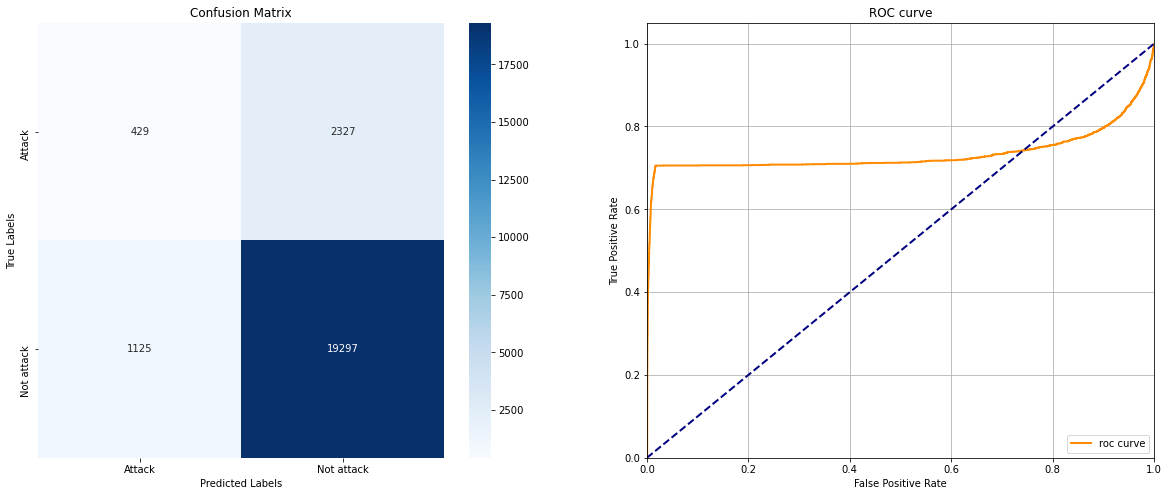

In [62]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
plt.figure(1, figsize=(20,8))

ax= plt.subplot(121)
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
ax.yaxis.set_ticklabels(['Attack', 'Not attack'])
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_prob_final)
plt.subplot(122)
lw = 2
plt.plot(fpr_rt_lm, tpr_rt_lm, color='darkorange',
         lw=lw, label='roc curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [47]:
prediction.metrics

{'eval_loss': 0.25504119737261105,
 'eval_accuracy': 0.9514625938389852,
 'eval_f1': 0.7847713793763154,
 'eval_precision': 0.830028328611898,
 'eval_recall': 0.7441944847605225}